In [ ]:
## INSTALL SPARK

!apt-get clean
!rm -rf /var/lib/apt/lists/*
!apt-get update
!apt-get upgrade

# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic InRelease [242 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Get:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.clustering import KMeans
from matplotlib import pyplot as plt

spark = SparkSession.builder.getOrCreate()

In [ ]:
#1
games = spark.read.option("inferSchema", "true").csv("Games.csv", header =True)
platforms = spark.read.option("inferSchema", "true").csv("Platforms.csv", header =True)
genres = spark.read.option("inferSchema", "true").csv("Genres.csv", header =True)
staffs = spark.read.option("inferSchema", "true").csv("Staffs.csv", header =True)
branches = spark.read.option("inferSchema", "true").csv("Branches.csv", header =True)
transactionheader = spark.read.option("inferSchema", "true").csv("TransactionHeader.csv", header =True)
transactiondetail = spark.read.option("inferSchema", "true").csv("TransactionDetail.csv", header =True)

In [ ]:
games.registerTempTable("games")
platforms.registerTempTable("platforms")
genres.registerTempTable("genres")
staffs.registerTempTable("staffs")
branches.registerTempTable("branches")
transactionheader.registerTempTable("transactionheader")
transactiondetail.registerTempTable("transactiondetail")

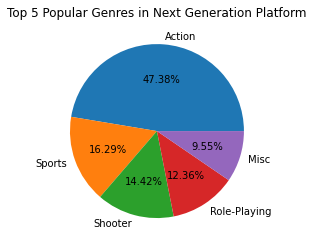

In [ ]:
#a.	Show the percentage of games released by genres that is in the next generation platform (“WiiU”,”PS4”,”XOne”) using pie plot.

data = spark.sql("""
          SELECT gen.genreid, gen.genrename, COUNT(gen.genreid) AS count
          FROM genres gen
          JOIN games ga ON gen.genreid = ga.genreid
          JOIN platforms p ON ga.platformid = p.platformid
          WHERE p.platformname = 'WiiU' OR
          p.platformname = 'PS4' OR
          p.platformname = 'XOne'
          GROUP BY gen.genreid, gen.genrename
          ORDER BY COUNT(gen.genreid) desc
          LIMIT 5
        """).toPandas()

plt.pie(data["count"], labels= data["genrename"], autopct="%.2f%%")
plt.title("Top 5 Popular Genres in Next Generation Platform")
plt.show()

           

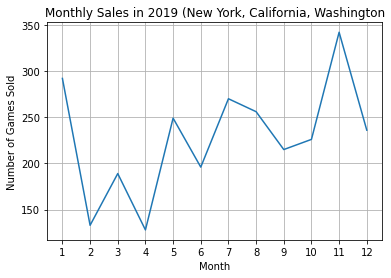

In [ ]:
# b.	Show the total number of games sold per month in 2019 in which the transaction 
# is done in “New York”, “California”, or “Washington” branch region using line plot.

data = spark.sql("""
SELECT month(th.transactiondate) AS month, sum(td.quantity) AS totalqty
FROM transactiondetail td 
JOIN transactionheader th on td.transactionid = th.transactionid
JOIN branches br on br.branchid = th.branchid
WHERE YEAR(th.transactiondate) = 2019
AND br.branchregion = 'New York' or br.branchregion = 'California'
OR br.branchregion = 'Washington'
GROUP BY month
ORDER BY month
""").toPandas()

plt.plot(data["month"],data["totalqty"])
plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Number of Games Sold")
plt.title("Monthly Sales in 2019 (New York, California, Washington")
plt.grid()
plt.show()


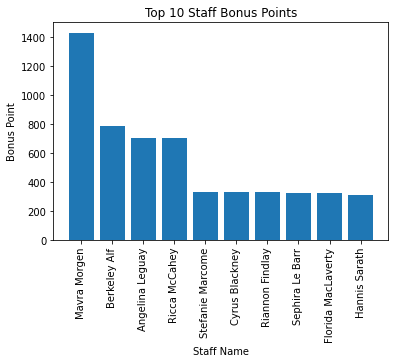

In [ ]:
# c.	Show bonus points for top 10 staff who handled the most number of transactions that does not occur in “New York” or “Alabama” branch using bar plot. 
# The bonus points are earned based on the following condition: 

# Games Sold Quantity	      Bonus Points
# > 400	Games              Sold Quantity * 3
# > 350	Games              Sold Quantity * 2
# <= 350	Games            Sold Quantity


data = spark.sql("""
SELECT staffname,
CASE
  WHEN COUNT > 400 THEN COUNT*3
  WHEN COUNT > 350 THEN COUNT*2
  WHEN COUNT <= 350 THEn COUNT
END AS bonus

FROM(
SELECT s.staffname AS staffname, SUM(td.quantity) AS count
FROM  staffs s
JOIN transactionheader th on s.staffid = th.staffid 
JOIN transactiondetail td on  th.transactionid= td.transactionid
JOIN branches br on th.branchid = br.branchid
WHERE br.branchregion != 'New York' AND br.branchregion != 'Alabama'
GROUP BY s.staffname
ORDER BY count desc
LIMIT 10)
""").toPandas()

plt.bar (data["staffname"], data["bonus"])
plt.title ("Top 10 Staff Bonus Points")
plt.xlabel("Staff Name")
plt.xticks(rotation=90)
plt.ylabel("Bonus Point")
plt.show()


In [ ]:
#Classification
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

# 1 load data
gametrain = spark.read.option("inferSchema", "true").csv("GameTrain.csv", header=True)
gametest = spark.read.option("inferSchema", "true").csv("GameTest.csv", header=True)

# 2 select features
gametrain = gametrain.select("Rating", "Popular", "SalesPerWeek", "Overall")
gametest = gametest.select("Rating", "Popular", "SalesPerWeek", "Overall")

from pyspark.sql.functions import when
from pyspark.ml.feature import VectorAssembler, StandardScaler

def preprocessing(data):
  #3 remove any missing values
  data = data.na.drop()

  #4 transform data
  data = data.withColumn("Rating", when(data['Rating'] == 'Low', 0).when(data['Rating'] == 'Average', 1).otherwise(2))
  data = data.withColumn("Popular", when(data['Popular'] == 'Yes', 1).otherwise(0))
  data = data.withColumn("Overall", when(data['Overall'] == 'Good', 1).otherwise(0))

 #5 normalization
  cols = data.columns
  cols.remove("Overall")
  data = VectorAssembler(inputCols=cols, outputCol="Features").transform(data)

  scaler = StandardScaler(inputCol="Features", outputCol="Scaled_Features")
  data = scaler.fit(data).transform(data)

  return data


In [ ]:
gametrain = preprocessing(gametrain)
gametest = preprocessing(gametest)

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
#6 generate model
model = LogisticRegression(featuresCol="Scaled_Features", labelCol="Overall", maxIter=10).fit(gametrain)

#7 model testing and evaluation
prediction = model.transform(gametest)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Overall")
print("Accuracy: {}".format(evaluator.evaluate(prediction)))

Accuracy: 0.9635148811975568
